# BTC-USD @5min

In [1]:
# PARAMS:
BC5M_FILENAME = './data_clean/btc.300s.cbpro.csv'
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [2]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import simple_plot
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


> size: 387948


datetime    datetime64[ns]
low                float64
high               float64
open               float64
close              float64
volume             float64
dtype: object

datetime     low    high    open   close      volume
timestamp                                                                 
1422745200 2015-01-31 23:00:00  224.51  225.69  225.38  224.51   29.638700
1422745500 2015-01-31 23:05:00  224.00  225.59  224.62  224.00   52.189176
1422745800 2015-01-31 23:10:00  221.99  223.92  223.91  221.99   40.262566
1422746100 2015-01-31 23:15:00  218.00  222.00  222.00  218.00  163.490760
1422746400 2015-01-31 23:20:00  217.11  218.89  217.92  218.22   96.317898

datetime      low     high     open    close     volume
timestamp                                                                    
1539128100 2018-10-09 23:35:00  6590.30  6593.48  6591.54  6590.30  17.148190
1539128400 2018-10-09 23:40:00  6586.55  6590.31  6590.31  6589.30  15.269094
1539128700 2018-10-09 23:45:00  6589.29  6589.69  6589.30  6589.48  12.466310
1539129000 2018-10-09 23:50:00  6589.47  6592.81  6589.48  6591.85  14.972801
1539129300 2018-10-09 23:55:00  6589.47  6592.81  6591.84  6589.48  31.305392

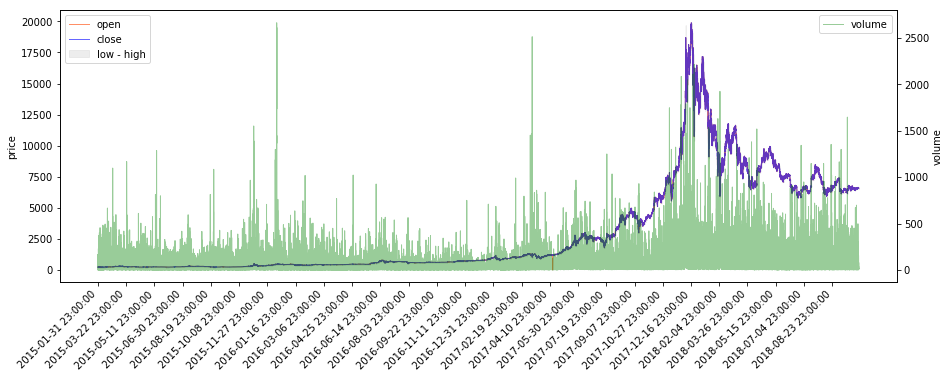

In [5]:
data5m = pd.read_csv(
    BC5M_FILENAME,
    index_col='timestamp',
    parse_dates=['datetime']
)
print('> size:', len(data5m))
dd(data5m.dtypes)
dd(data5m.head())
dd(data5m.tail())
simple_plot(data5m, xticks_span=30 * 24 * 60 // 3)

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [27]:
# %matplotlib qt

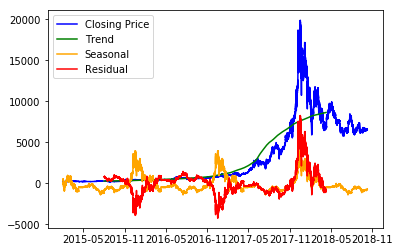

In [7]:
dec = seasonal_decompose(
    data5m['close'].values,
    freq=365 * 24 * 60 // 5  # yearly
)
xs = data5m['datetime'].values
plt.figure()
plt.plot(xs, data5m['close'].values, color='b', label='Closing Price')
plt.plot(xs, dec.trend, color='green', label='Trend')
plt.plot(xs, dec.seasonal, color='orange', label='Seasonal')
plt.plot(xs, dec.resid, color='red', label='Residual')
plt.legend()
plt.show()

## Test runs (laptop)

### LR

data ~ (1600, 1)
--- 0.000s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210)...
> Predicting (now at 220)...
> Predicting (now at 230)...
> Predicting (now at 240)...
> Predicting (now at 250)...
> Predicting (now at 260)...
> Predicting (now at 270)...
> Predicting (now at 280)...
> Predicting (now at 290)...
> Predicting (now at 300)...
> Predicting (now at 310)...
> Predicting (now at 320)...
> Predicti

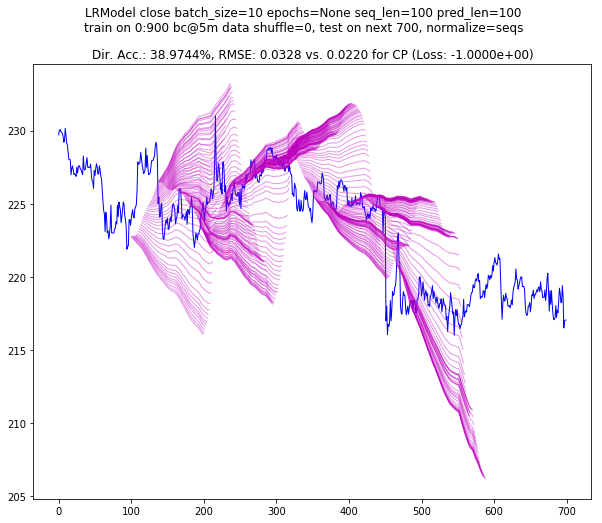

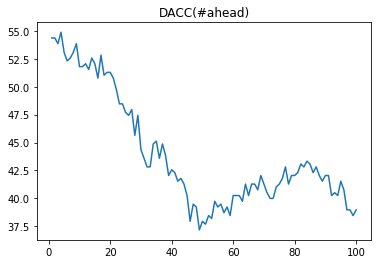

--- 12.032s to run experiment



In [30]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=1000 - 100,
        test_sz=500 + 200,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=LRModel,
        # training:
        epochs=None,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=False,
    )

data ~ (28000, 1)
--- 0.000s to train model

--- 0.608s to walk and predict

--- 0.022s to plot incremental predictions



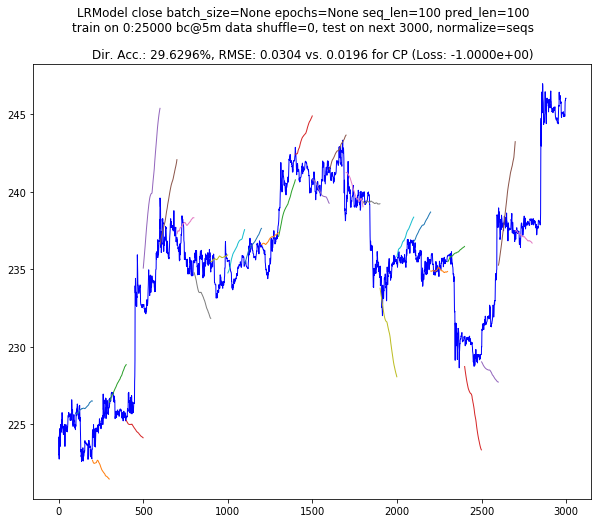

--- 1.143s to run experiment



In [7]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=LRModel,
        # training:
        epochs=None,
        batch_size=None,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (28000, 1)
--- 0.000s to train model

--- 0.752s to walk and predict

--- 0.032s to plot incremental predictions



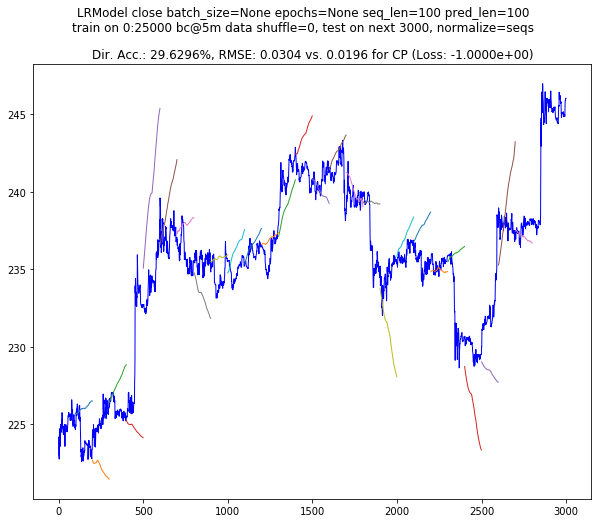

--- 1.122s to run experiment



In [25]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=LRModel,
        # training:
        epochs=None,
        batch_size=None,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [28]:
with timing('run experiment'):
    r = run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=101,
        test_sz=len(data5m) - 101,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=LRModel,
        # training:
        epochs=None,
        batch_size=None,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        plot=False,
        fig_size=(10, 8),
        fast=True,
    )
    print("> results:")
    dd(r)

data ~ (387948, 1)
--- 0.000s to train model

--- 105.992s to walk and predict

> results:


{'dir_acc': u'30.6760%',
 'model_description': u'LRModel close batch_size=None epochs=None seq_len=100 pred_len=100',
 'normalize': u'seqs',
 'rmse': u'0.0545%',
 'rmse_cp': u'0.0320%',
 'shuffle': False,
 'test_on': 387847,
 'train_from': 0,
 'train_to': 101,
 'training_loss': u'-1.0000e+00)'}

--- 108.527s to run experiment



**LR Model conclusion:** Significantly worse than random guessing at direction prediction. Significantly higher RMSE than constant prediction. This model is obviously not adequate for this type of data.

### ARIMA

In [8]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA

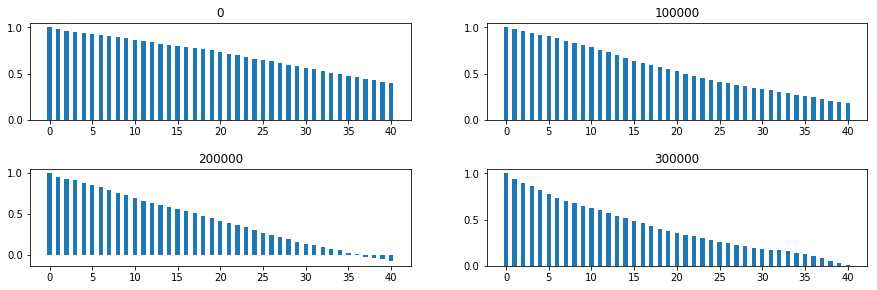

In [9]:
plt.figure(figsize=(15, 5), facecolor='white')
plt.subplots_adjust(top=0.8, hspace=0.5)
for i, n in enumerate([0, 100000, 200000, 300000]):
    plt.subplot(2, 2, i + 1)
    plt.title(str(n))
    data_acf = acf(data5m[n: n + 300]['close'].values)
    plt.bar(np.arange(len(data_acf)), data_acf, width=0.5)

**Conclusion:** looks like an AR process (cannot exclude an MA component though).

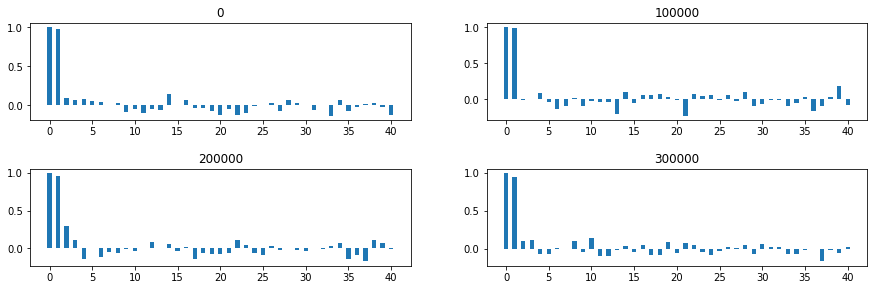

In [12]:
plt.figure(figsize=(15, 5), facecolor='white')
plt.subplots_adjust(top=0.8, hspace=0.5)
for i, n in enumerate([0, 100000, 200000, 300000]):
    plt.subplot(2, 2, i + 1)
    plt.title(str(n))
    data_pacf = pacf(data5m[n: n + 300]['close'].values)
    plt.bar(np.arange(len(data_pacf)), data_pacf, width=0.5)

**Conclusion:** AR(2), maybe AR(3).

Worth trying:
- (2, 0, 0) !
- (2, 1, 0)
- (2, 0, 1) !
- (2, 0, 2)
- (3, 0, 0)
- (3, 0, 1)

/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: invalid value encountered in divide
  (1+np.exp(-params))).copy()
/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: invalid valu

--- 111.247s to run experiment



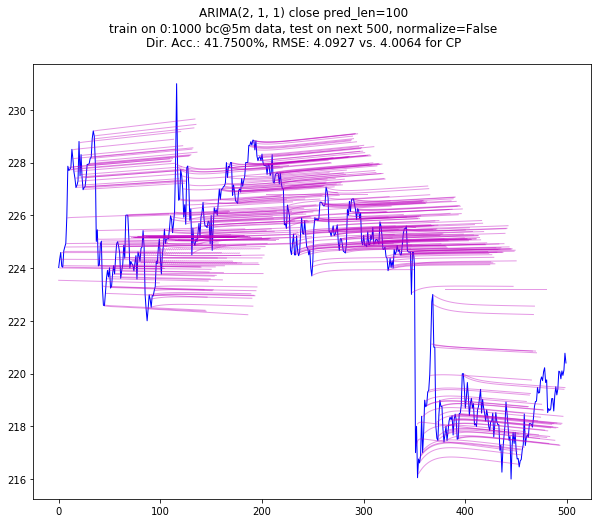

In [14]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=1000,
        test_sz=500,
        # data processing:
        normalize=False,
        order=(2, 1, 1),
        pred_len=100,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

--- 175.902s to run experiment



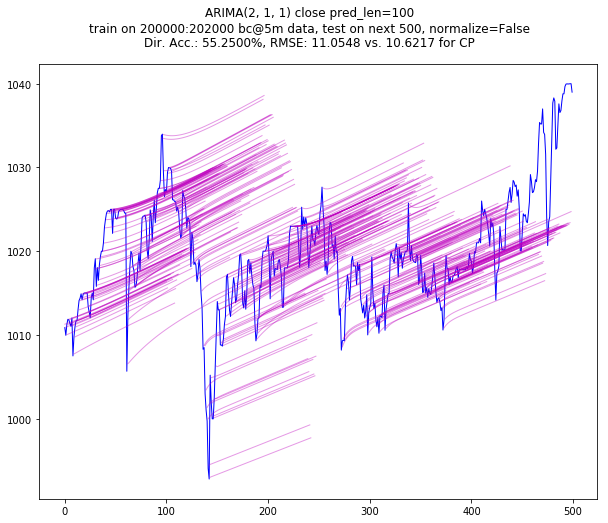

In [20]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=2000,
        test_sz=500,
        # data processing:
        normalize=False,
        order=(2, 1, 1),
        pred_len=100,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

--- 14.555s to run experiment



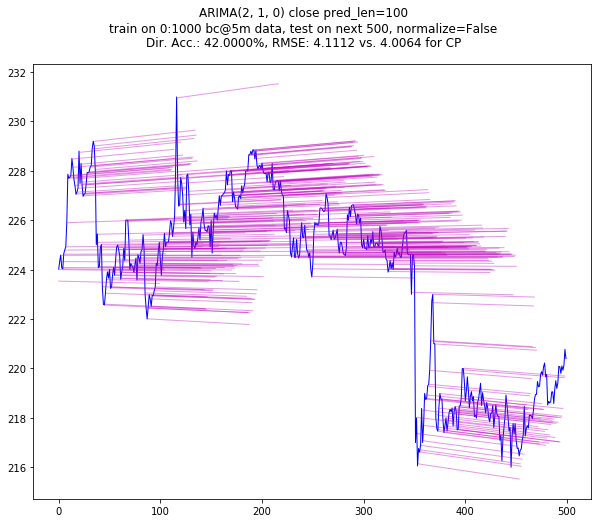

In [15]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=1000,
        test_sz=500,
        # data processing:
        normalize=False,
        order=(2, 1, 1),
        pred_len=100,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/base/mo

--- 137.601s to run experiment



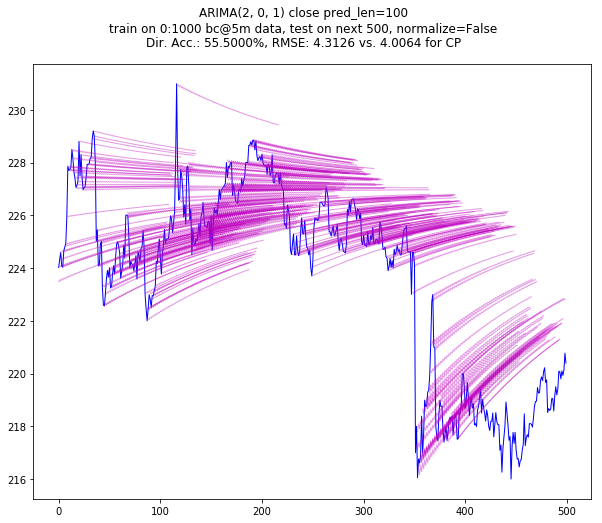

In [16]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=1000,
        test_sz=500,
        # data processing:
        normalize=False,
        order=(2, 0, 1),
        pred_len=100,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=5000,
        test_sz=1000,
        # data processing:
        normalize=False,
        order=(2, 1, 1),
        pred_len=100,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=5000,
        test_sz=1000,
        # data processing:
        normalize=False,
        order=(2, 0, 1),
        pred_len=7,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

### LSTM

data ~ (28000, 1)
--- 0.016s to model compilation time


--- Created model id: 140674197193424
Tensor("lstm_117_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_117 (LSTM)              (None, 100, 100)          40800     
_________________________________________________________________
dropout_117 (Dropout)        (None, 100, 100)          0         
_________________________________________________________________
lstm_118 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dropout_118 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
________________________________________________

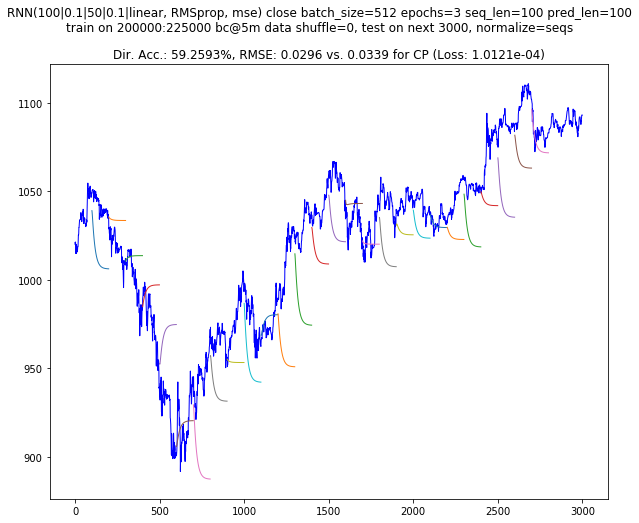

--- 57.756s to run experiment



In [35]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        plot=True,
        fig_size=(10, 8),
        fast=True,
    )

In [41]:
with timing('run experiment'):
    r = run_walk_forward_validation_rnn_retraining(
        # data to extract:
        data5m,
        features=['close'],
        from_i=199000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        plot=False,
        fig_size=(10, 8),
        fast=True,
    )
    print("> results:")
    dd(r)

# > results:
# {'dir_acc': u'42.8571%',
#  'model_description': u'RNN(100|0.1|50|0.1|linear, RMSprop, mse) close batch_size=512 epochs=3 seq_len=100 pred_len=100',
#  'normalize': u'seqs',
#  'rmse': u'0.6304%',
#  'rmse_cp': u'0.0024%',
#  'shuffle': False,
#  'test_on': 3000,
#  'train_from': 199000,
#  'train_to': 224000,
#  'training_loss': u'8.8943e-05)'}
# --- 2028.719s to run experiment

data ~ (28000, 1)

====== 0
                x_train_seqs ~ (24899, 100, 1) [...0.0299132129117]
                y_train ~ (24899, 1) [...[0.03524172]]
                x_test_seqs ~ (1, 100, 1) [...-0.00582608695652]
                y_test ~ (1, 1) [...[-0.00404831]]
                
--- 0.015s to model compilation time


--- Created model id: 140674256300304
Tensor("lstm_215_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_215 (LSTM)              (None, 100, 100)          40800     
_________________________________________________________________
dropout_215 (Dropout)        (None, 100, 100)          0         
_________________________________________________________________
lstm_216 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dropout_216 (Dropout)        (None, 50)           

{'dir_acc': u'42.8571%',
 'model_description': u'RNN(100|0.1|50|0.1|linear, RMSprop, mse) close batch_size=512 epochs=3 seq_len=100 pred_len=100',
 'normalize': u'seqs',
 'rmse': u'0.6304%',
 'rmse_cp': u'0.0024%',
 'shuffle': False,
 'test_on': 3000,
 'train_from': 199000,
 'train_to': 224000,
 'training_loss': u'8.8943e-05)'}

--- 2028.719s to run experiment



In [42]:
with timing('run experiment'):
    r = run_walk_forward_validation_rnn_retraining(
        # data to extract:
        data5m,
        features=['close'],
        from_i=301000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        plot=False,
        fig_size=(10, 8),
        fast=True,
    )
    print("> results:")
    dd(r)

# > results:
# {'dir_acc': u'42.8571%',
#  'model_description': u'RNN(100|0.1|50|0.1|linear, RMSprop, mse) close batch_size=512 epochs=3 seq_len=100 pred_len=100',
#  'normalize': u'seqs',
#  'rmse': u'0.6304%',
#  'rmse_cp': u'0.0024%',
#  'shuffle': False,
#  'test_on': 3000,
#  'train_from': 199000,
#  'train_to': 224000,
#  'training_loss': u'8.8943e-05)'}
# --- 2028.719s to run experiment

data ~ (28000, 1)

====== 0
                x_train_seqs ~ (24899, 100, 1) [...-0.0286574107846]
                y_train ~ (24899, 1) [...[-0.03420457]]
                x_test_seqs ~ (1, 100, 1) [...-0.0947913682549]
                y_test ~ (1, 1) [...[-0.10587232]]
                
--- 0.015s to model compilation time


--- Created model id: 140672507088976
Tensor("lstm_271_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_271 (LSTM)              (None, 100, 100)          40800     
_________________________________________________________________
dropout_271 (Dropout)        (None, 100, 100)          0         
_________________________________________________________________
lstm_272 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dropout_272 (Dropout)        (None, 50)          

{'dir_acc': u'64.2857%',
 'model_description': u'RNN(100|0.1|50|0.1|linear, RMSprop, mse) close batch_size=512 epochs=3 seq_len=100 pred_len=100',
 'normalize': u'seqs',
 'rmse': u'0.8575%',
 'rmse_cp': u'0.0040%',
 'shuffle': False,
 'test_on': 3000,
 'train_from': 301000,
 'train_to': 326000,
 'training_loss': u'1.7059e-04)'}

--- 2225.945s to run experiment



## Test runs (server)

### ARIMA

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=5000,
        test_sz=1000,
        # data processing:
        normalize=False,
        order=(2, 0, 0),
        pred_len=100,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=5000,
        test_sz=1000,
        # data processing:
        normalize=False,
        order=(2, 0, 1),
        pred_len=7,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=5000,
        test_sz=1000,
        # data processing:
        normalize=False,
        order=(2, 0, 1),
        pred_len=100,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=5000,
        test_sz=1000,
        # data processing:
        normalize=False,
        order=(2, 0, 2),
        pred_len=100,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=5000,
        test_sz=1000,
        # data processing:
        normalize=False,
        order=(3, 0, 1),
        pred_len=100,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=5000,
        test_sz=1000,
        # data processing:
        normalize=False,
        order=(2, 1, 0),
        pred_len=100,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=5000,
        test_sz=1000,
        # data processing:
        normalize=False,
        order=(2, 1, 1),
        pred_len=100,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=200,
        # data processing:
        normalize=False,
        order=(2, 0, 1),
        pred_len=10,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=1000,
        test_sz=200,
        # data processing:
        normalize=False,
        order=(2, 0, 1),
        pred_len=10,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=1000,
        test_sz=200,
        # data processing:
        normalize=False,
        order=(3, 0, 1),
        pred_len=10,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=1000,
        test_sz=200,
        # data processing:
        normalize=False,
        order=(4, 0, 1),
        pred_len=10,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=1000,
        test_sz=200,
        # data processing:
        normalize=False,
        order=(4, 0, 1),
        pred_len=50,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=1000,
        test_sz=200,
        # data processing:
        normalize=False,
        order=(4, 0, 1),
        pred_len=100,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_arima(
        # data to extract:
        data5m,
        features=['close'],
        from_i=0,
        train_sz=5000,
        test_sz=1000,
        # data processing:
        normalize=False,
        order=(4, 0, 1),
        pred_len=100,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
    )

### LSTM

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=5000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=2,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=5000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=5000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=6,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=5000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=8,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=5000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.2, 50, 0.2]),
        # training:
        epochs=6,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=5000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1], lr=5e-4),
        # training:
        epochs=6,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=6,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=10,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.2, 50, 0.2]),
        # training:
        epochs=10,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.2, 50, 0.2]),
        # training:
        epochs=3,
        batch_size=128,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=128,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor(
            [100, 0.1, 50, 0.1],
            optimizer=keras.optimizers.Nadam,
            lr=0.002
        ),
        # training:
        epochs=3,
        batch_size=128,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (53000, 1)
train_sz = 50000

seqs ~ (52899, 101, 1)
--- 0.017s to model compilation time


--- Created model id: 140436695757968
Tensor("lstm_1_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________

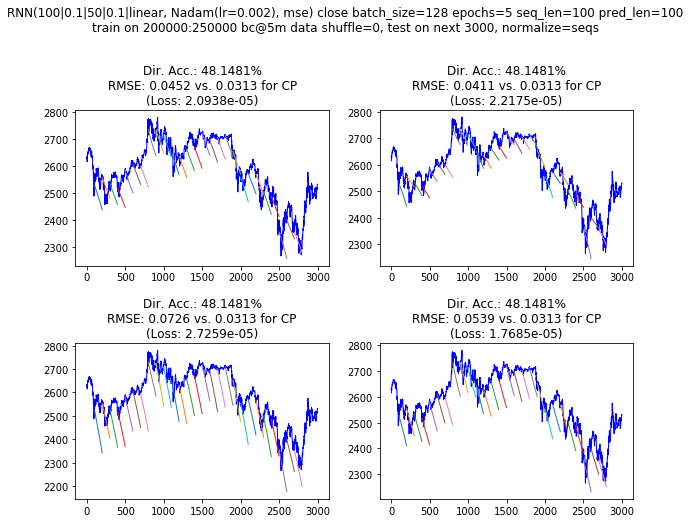

--- 2002.971s to run experiment



In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor(
            [100, 0.1, 50, 0.1],
            optimizer=keras.optimizers.Nadam,
            lr=0.002
        ),
        # training:
        epochs=5,
        batch_size=128,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (53000, 1)
train_sz = 50000

seqs ~ (52899, 101, 1)
--- 0.016s to model compilation time


--- Created model id: 140390536896016
Tensor("lstm_1_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________

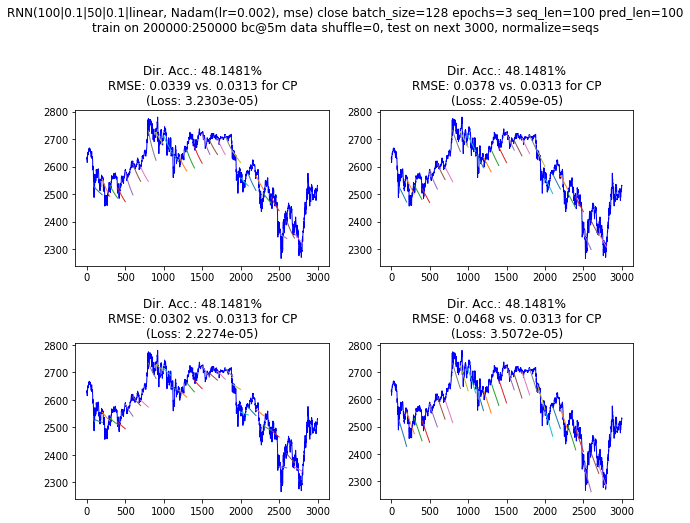

--- 1210.504s to run experiment



In [6]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor(
            [100, 0.1, 50, 0.1],
            optimizer=keras.optimizers.Nadam,
            lr=0.002
        ),
        # training:
        epochs=3,
        batch_size=128,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (53000, 1)
train_sz = 50000

seqs ~ (52899, 101, 1)
--- 0.017s to model compilation time


--- Created model id: 140386021544528
Tensor("lstm_9_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________

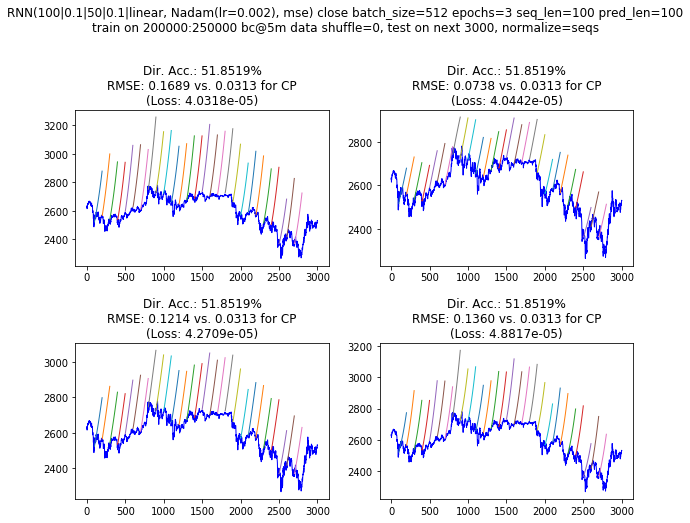

--- 333.984s to run experiment



In [7]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor(
            [100, 0.1, 50, 0.1],
            optimizer=keras.optimizers.Nadam,
            lr=0.002
        ),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

# > results:
# {'dir_acc': u'64.2857%',
#  'model_description': u'RNN(100|0.1|50|0.1|linear, RMSprop, mse) close batch_size=512 epochs=3 seq_len=100 pred_len=100',
#  'normalize': u'seqs',
#  'rmse': u'0.8575%',
#  'rmse_cp': u'0.0040%',
#  'shuffle': False,
#  'test_on': 3000,
#  'train_from': 301000,
#  'train_to': 326000,
#  'training_loss': u'1.7059e-04)'}
# --- 2225.945s to run experiment

data ~ (53000, 1)
train_sz = 50000

seqs ~ (52899, 101, 1)
--- 0.020s to model compilation time


--- Created model id: 140385604973840
Tensor("lstm_17_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_17 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
________

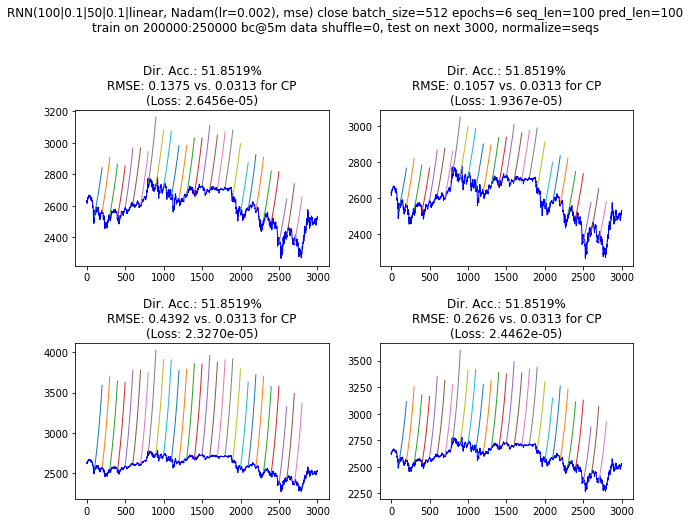

--- 638.508s to run experiment



In [8]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor(
            [100, 0.1, 50, 0.1],
            optimizer=keras.optimizers.Nadam,
            lr=0.002
        ),
        # training:
        epochs=6,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (53000, 1)
train_sz = 50000

seqs ~ (52899, 101, 1)
--- 0.017s to model compilation time


--- Created model id: 140385508908944
Tensor("lstm_25_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_25 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
________

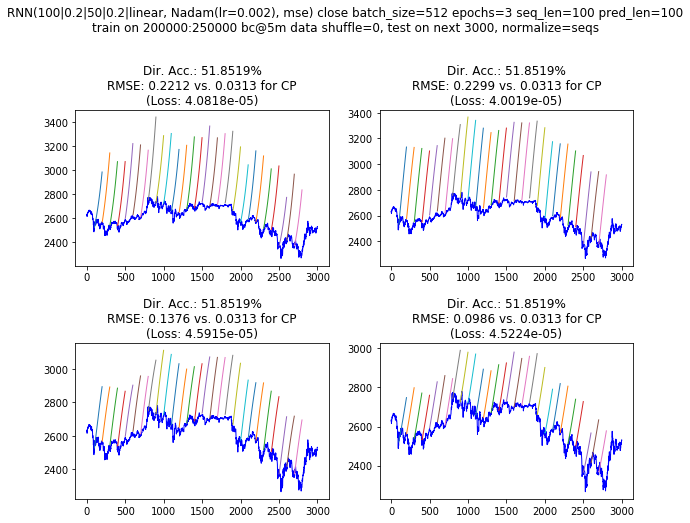

--- 345.123s to run experiment



In [9]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor(
            [100, 0.2, 50, 0.2],
            optimizer=keras.optimizers.Nadam,
            lr=0.002
        ),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (53000, 1)
train_sz = 50000

seqs ~ (52899, 101, 1)
--- 0.017s to model compilation time


--- Created model id: 140385414131792
Tensor("lstm_35_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_35 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_36 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
________

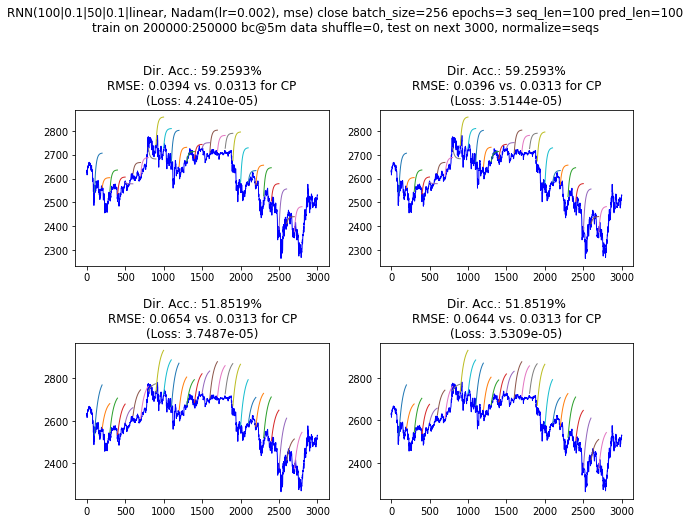

--- 641.390s to run experiment



In [11]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor(
            [100, 0.1, 50, 0.1],
            optimizer=keras.optimizers.Nadam,
            lr=0.002
        ),
        # training:
        epochs=3,
        batch_size=256,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (53000, 1)
train_sz = 50000

seqs ~ (52899, 101, 1)
--- 0.017s to model compilation time


--- Created model id: 140385245036880
Tensor("lstm_43_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_43 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_44 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
________

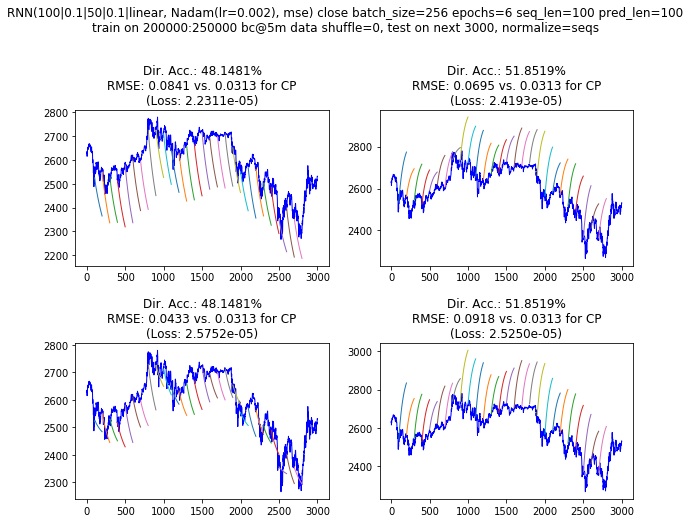

--- 1243.116s to run experiment



In [12]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor(
            [100, 0.1, 50, 0.1],
            optimizer=keras.optimizers.Nadam,
            lr=0.002
        ),
        # training:
        epochs=6,
        batch_size=256,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140385103567760
Tensor("lstm_51_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_51 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_52 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
________

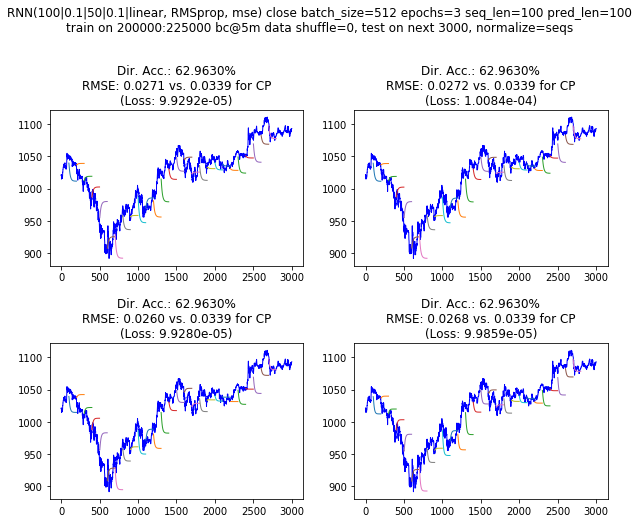

--- 205.693s to run experiment



In [13]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (53000, 1)
train_sz = 50000

seqs ~ (52899, 101, 1)
--- 0.016s to model compilation time


--- Created model id: 140384874475728
Tensor("lstm_75_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_75 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_76 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_76 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
________

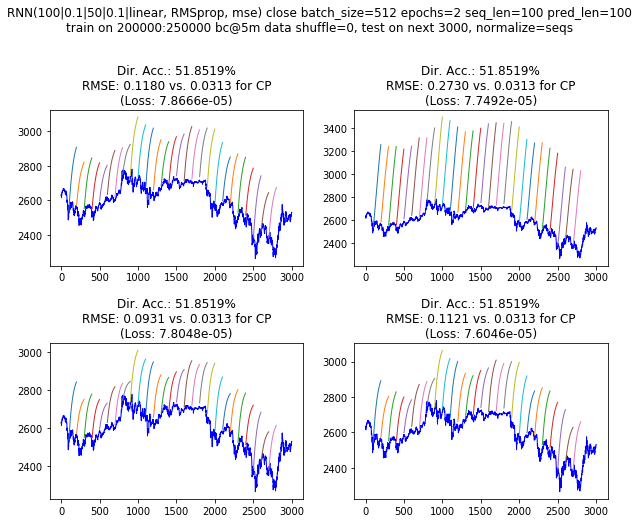

--- 264.884s to run experiment



In [16]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=2,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (53000, 1)
train_sz = 50000

seqs ~ (52899, 101, 1)
--- 0.016s to model compilation time


--- Created model id: 140384693847504
Tensor("lstm_83_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_83 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_83 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_84 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_84 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
________

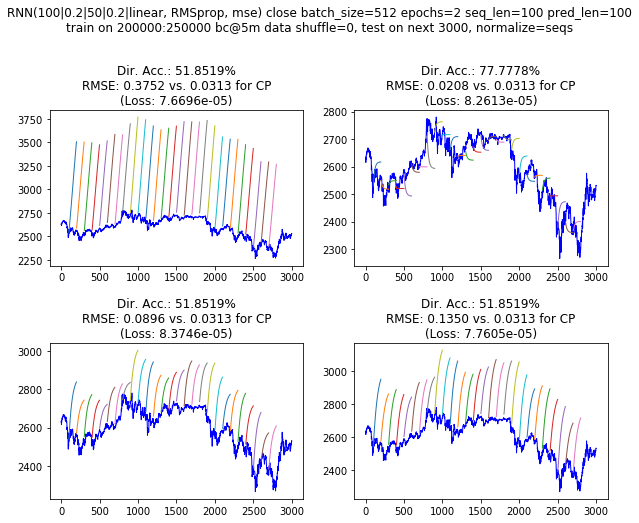

--- 270.138s to run experiment



In [17]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.2, 50, 0.2]),
        # training:
        epochs=2,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (53000, 1)
train_sz = 50000

seqs ~ (52899, 101, 1)
--- 0.018s to model compilation time


--- Created model id: 140384751594128
Tensor("lstm_91_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_91 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_91 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_92 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_92 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
________

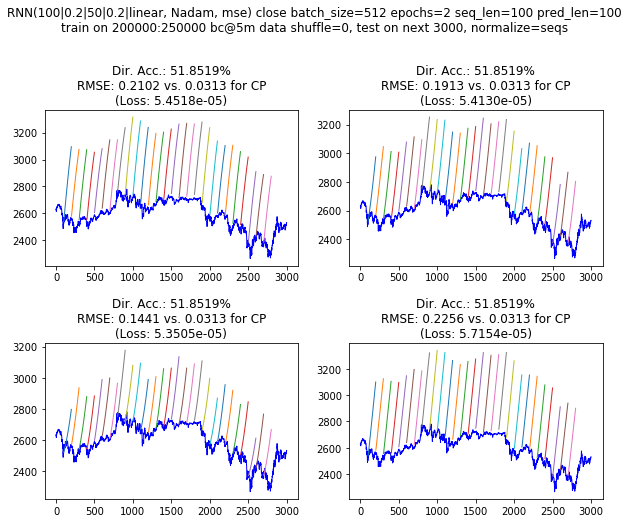

--- 272.058s to run experiment



In [18]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor(
            [100, 0.2, 50, 0.2],
            optimizer=keras.optimizers.Nadam
        ),
        # training:
        epochs=2,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (53000, 1)
train_sz = 50000

seqs ~ (52899, 101, 1)
--- 0.017s to model compilation time


--- Created model id: 140384504153488
Tensor("lstm_99_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_99 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_99 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_100 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dropout_100 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
________

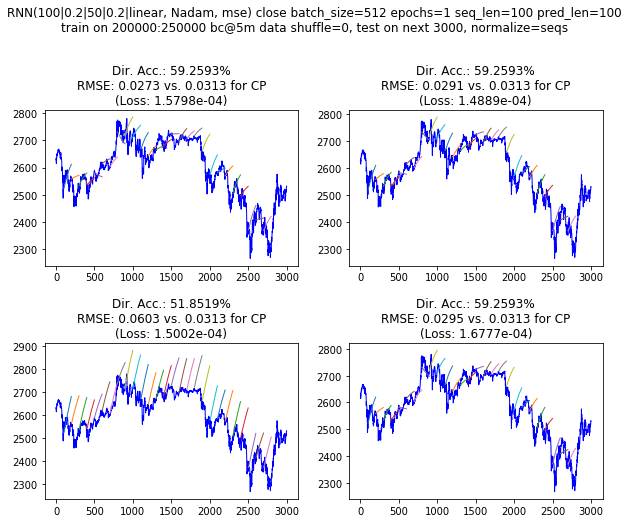

--- 178.197s to run experiment



In [19]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor(
            [100, 0.2, 50, 0.2],
            optimizer=keras.optimizers.Nadam
        ),
        # training:
        epochs=1,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (53000, 1)
train_sz = 50000

seqs ~ (52899, 101, 1)
--- 0.018s to model compilation time


--- Created model id: 140384306557072
Tensor("lstm_115_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_115 (LSTM)              (None, 100, 100)          40800     
_________________________________________________________________
dropout_115 (Dropout)        (None, 100, 100)          0         
_________________________________________________________________
lstm_116 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dropout_116 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_______

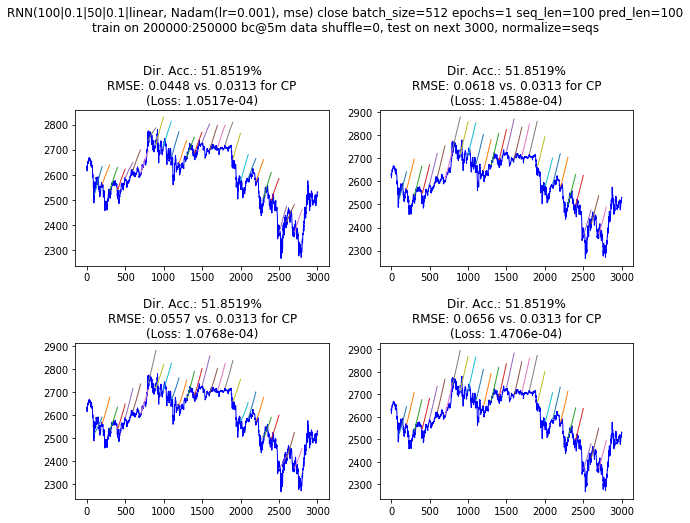

--- 183.172s to run experiment



In [21]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=50000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor(
            [100, 0.1, 50, 0.1],
            optimizer=keras.optimizers.Nadam,
            lr=1e-3
        ),
        # training:
        epochs=1,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140024618510416
Tensor("lstm_1_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________

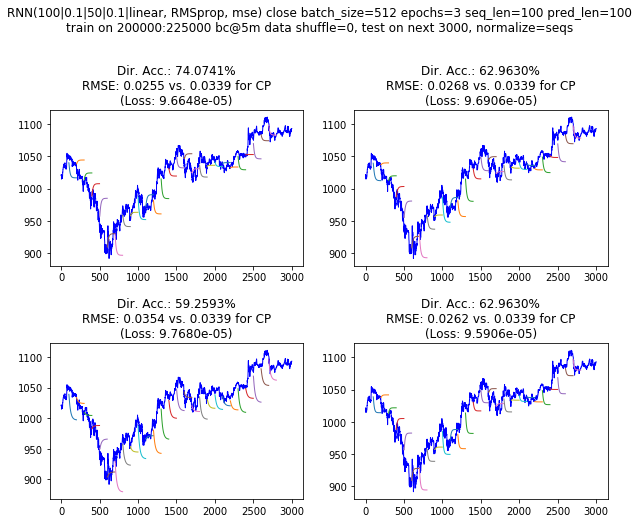

--- 195.436s to run experiment



In [6]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (13000, 1)
train_sz = 10000

seqs ~ (12899, 101, 1)
--- 0.016s to model compilation time


--- Created model id: 139785237934544
Tensor("lstm_1_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________

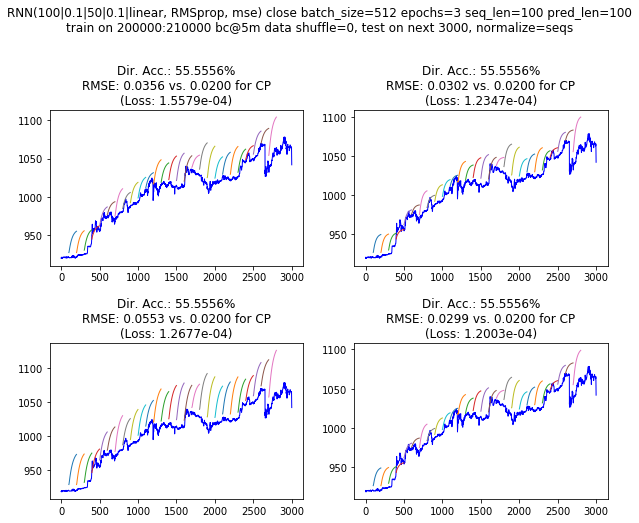

--- 94.841s to run experiment



In [12]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=10000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (38000, 1)
train_sz = 35000

seqs ~ (37899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 139782961257296
Tensor("lstm_9_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________

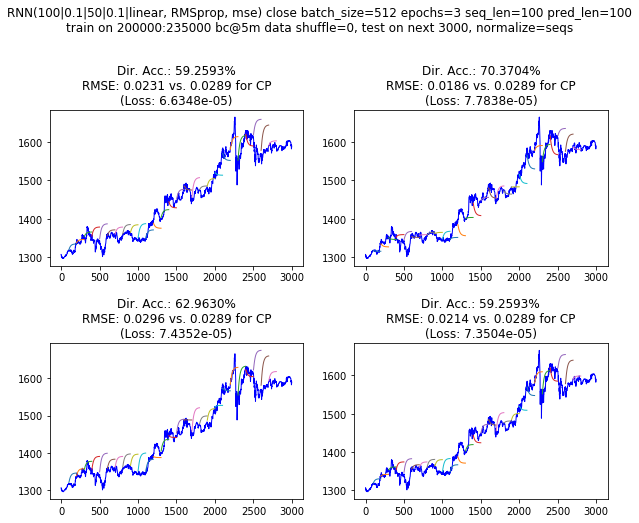

--- 247.112s to run experiment



In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=35000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [ ]:
###################################################################################

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140153545150992
Tensor("lstm_1_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________

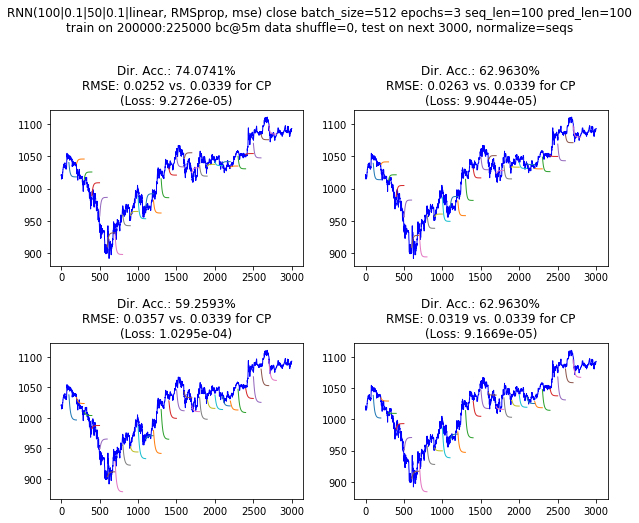

--- 185.946s to run experiment



In [6]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (30000, 1)
train_sz = 25000

seqs ~ (29899, 101, 1)
--- 0.016s to model compilation time


--- Created model id: 140151646816464
Tensor("lstm_9_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________

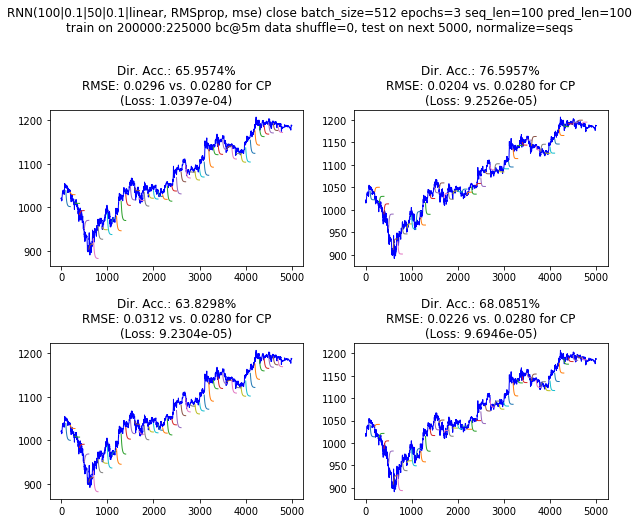

--- 208.200s to run experiment



In [7]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=25000,
        test_sz=5000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (30000, 1)
train_sz = 25000

seqs ~ (29899, 101, 1)
--- 0.016s to model compilation time


--- Created model id: 140150925219024
Tensor("lstm_17_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_17 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
________

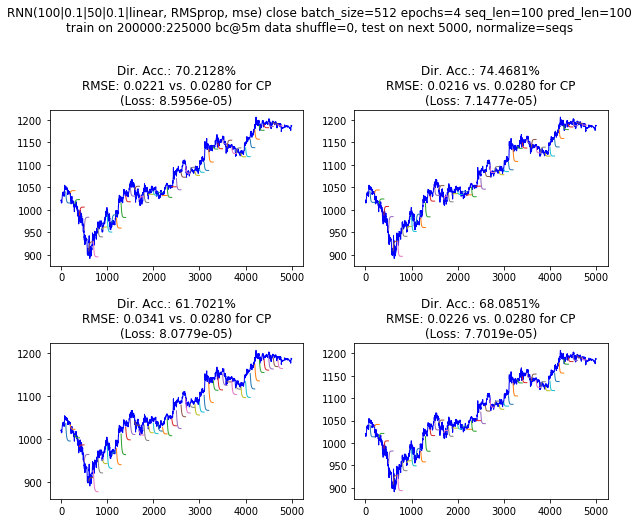

--- 261.687s to run experiment



In [8]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=25000,
        test_sz=5000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=4,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (35000, 1)
train_sz = 25000

seqs ~ (34899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140150762044496
Tensor("lstm_33_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_33 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_34 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
________

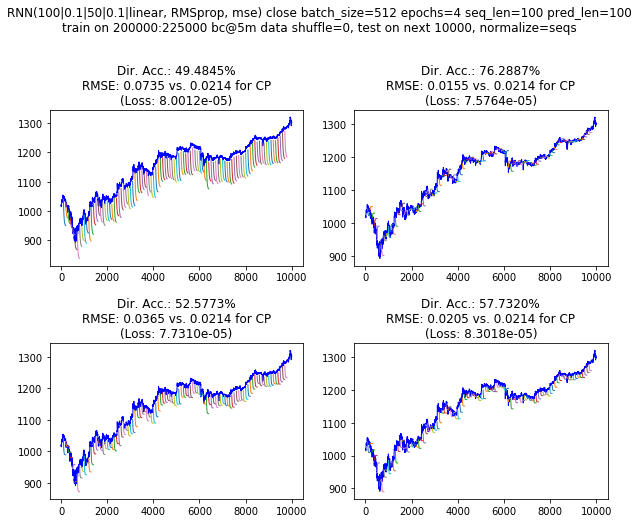

--- 307.382s to run experiment



In [10]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=25000,
        test_sz=10000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=4,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (35000, 1)
train_sz = 25000

seqs ~ (34899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140150639222352
Tensor("lstm_41_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_41 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_42 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
________

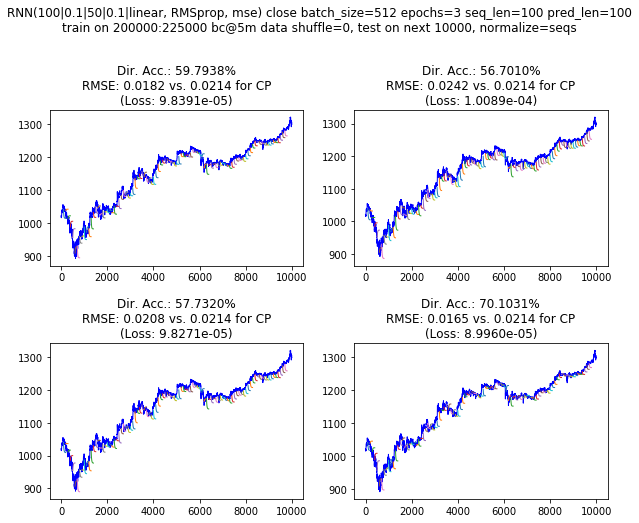

--- 261.391s to run experiment



In [11]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=25000,
        test_sz=10000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [13]:
5000 * 300 / (24 * 60 * 60)

17.36111111111111

In [14]:
10000 * 300 / (24 * 60 * 60)

34.72222222222222

data ~ (50000, 1)
train_sz = 25000

seqs ~ (49899, 101, 1)
--- 0.017s to model compilation time


--- Created model id: 140150576732816
Tensor("lstm_49_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_49 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_50 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
________

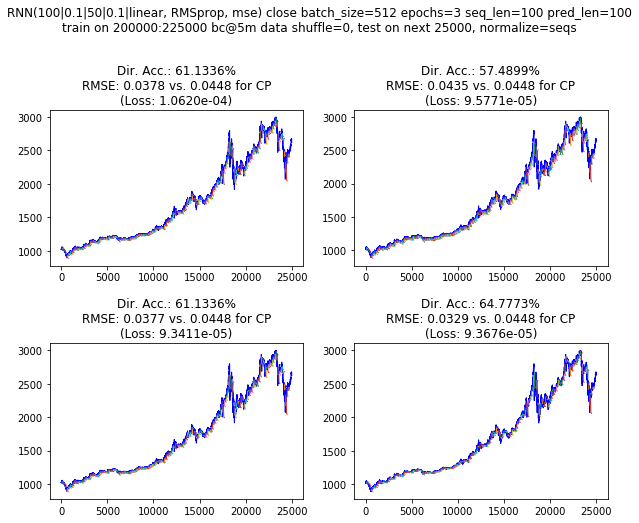

--- 346.466s to run experiment



In [15]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=25000,
        test_sz=25000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (30000, 1)
train_sz = 25000

seqs ~ (29899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140483420056656
Tensor("lstm_1_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________

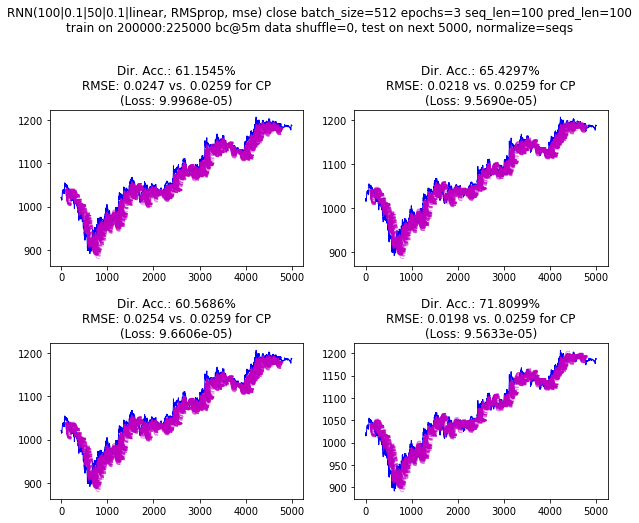

--- 2976.126s to run experiment



In [6]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close'],
        from_i=200000,
        train_sz=25000,
        test_sz=5000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )